### Множественная линейная регрессия

Множественная регрессия с одной переменной
Существует линейная связь между зависимыми и независимыми переменными. 
Отсутствие значительной корреляции между независимыми переменными.

In [1]:
import datetime
 
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
import plotly
import statsmodels
import statsmodels.tsa.arima_process

import seaborn as sns
sns.set()

In [2]:
# настройки отображения графиков
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
data_for_model = pd.read_csv('Test_1.csv', sep=';', engine='python', encoding='Windows 1251', decimal= ',')
data_for_model.head()

,City,Date,Регистрации_organic,Переходы_paid,Регистрации_paid,T,RRR,sss,Orders_all,Orders_with_coupon,Num_of_OOH,OTS,Reach,Google Trends,Яндекс Вордстат,TVR
0,Москва,01.01.2018,88,0,16,0.9125,0.0,0.0,17100,0,0,0,0.0,NaN,NaN,0.0
1,Москва,02.01.2018,16,0,0,1.9375,0.0,0.0,11010,0,0,0,0.0,NaN,NaN,0.0
2,Москва,03.01.2018,8,0,0,2.3875,0.6,0.0,11040,0,0,0,0.0,NaN,NaN,0.0
3,Москва,04.01.2018,0,0,8,2.0375,0.0,0.0,11190,0,0,0,0.0,NaN,NaN,0.0
4,Москва,07.01.2018,0,0,0,1.8250,1.3,0.0,13260,0,0,0,0.0,NaN,NaN,0.0


In [4]:
data_for_model['Date']= pd.to_datetime(data_for_model['Date'])
print(data_for_model['Date'].max())
print(data_for_model['Date'].min())

2020-12-06 00:00:00
2018-01-01 00:00:00


In [5]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5762 entries, 0 to 5761
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   City                 5762 non-null   object        
 1   Date                 5762 non-null   datetime64[ns]
 2   Регистрации_organic  5762 non-null   int64         
 3   Переходы_paid        5762 non-null   int64         
 4   Регистрации_paid     5762 non-null   int64         
 5   T                    5762 non-null   float64       
 6   RRR                  5762 non-null   float64       
 7   sss                  5762 non-null   float64       
 8   Orders_all           5762 non-null   int64         
 9   Orders_with_coupon   5762 non-null   int64         
 10  Num_of_OOH           5762 non-null   int64         
 11  OTS                  5762 non-null   int64         
 12  Reach                5762 non-null   float64       
 13  Google Trends        5571 non-nul

In [22]:
# Список долей отсутствующих записей для каждого признака
for col in data_for_model.columns:
    pct_missing = np.mean(data_for_model[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))

City - 0%
Date - 0%
Регистрации_organic - 0%
Переходы_paid - 0%
Регистрации_paid - 0%
RRR - 0%
Orders_all - 0%
Orders_with_coupon - 0%
Num_of_OOH - 0%
Reach - 0%
Google_Trends_ - 0%
TVR - 0%


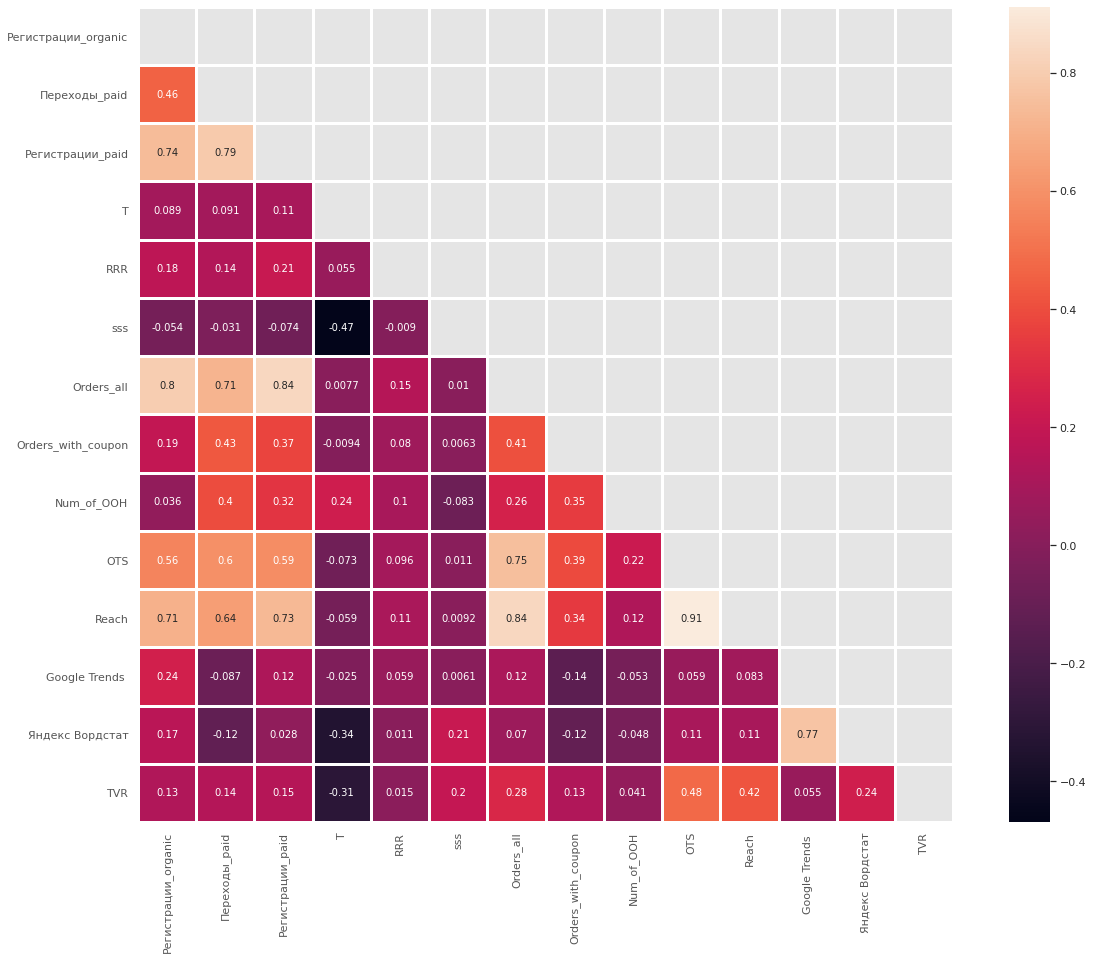

In [7]:
# матрица корреляции 
fig, ax = plt.subplots(figsize=(20, 15))
corr = data_for_model.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('dark'):
    ax = sns.heatmap(corr,
                     mask=mask,
                     square=True,
                     cbar=True,
                     annot=True,
                     linewidths=3)

In [8]:
# Переименование столбцов
data_for_model = data_for_model.rename(columns=lambda x: x.replace(' ', '_'))

In [9]:
# Замена отсутствующих значений в столбце Google Trends
data_for_model['Google_Trends_'] = data_for_model['Google_Trends_'].fillna(0)

In [10]:
data_for_model = data_for_model.drop(['OTS', 'T', 'Яндекс_Вордстат','sss'], axis=1)

<AxesSubplot:>

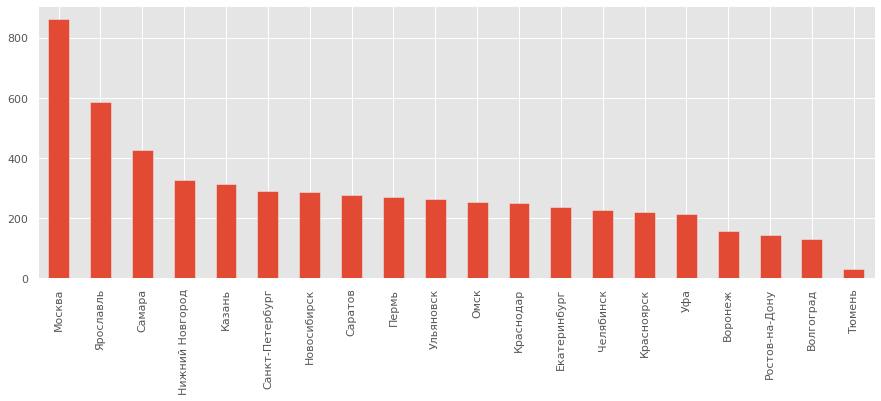

In [11]:
# Количество исследуемых дней по городам
data_for_model['City'].value_counts().plot.bar()

In [18]:
data_for_model['City'].value_counts()

Москва             861
Ярославль          587
Самара             427
Нижний Новгород    326
Казань             312
Санкт-Петербург    291
Новосибирск        285
Саратов            276
Пермь              270
Ульяновск          263
Омск               254
Краснодар          249
Екатеринбург       235
Челябинск          228
Красноярск         221
Уфа                214
Воронеж            158
Ростов-на-Дону     144
Волгоград          130
Тюмень              31
Name: City, dtype: int64

In [26]:
data_for_model['dup_number'] = data_for_model.groupby(['City']).transform(np.size)

ValueError: Wrong number of items passed 11, placement implies 1

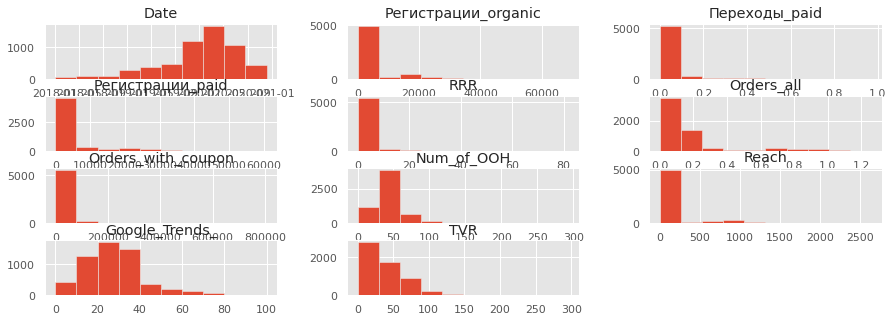

In [20]:

data_for_model.hist();

### А) сколько платежей в каждом городе принесла ТВ-кампания 

(с обоснованием валидности расчетов и оценкой качества модели)

In [ ]:
sns.kdeplot(data=data_for_model, x='Date', hue='City')

In [ ]:

df = with_reach[data_for_model['City'] == 'Москва']

In [ ]:

# Размещение заказов
x = df.Date
y = df.Orders_all
sns.lineplot(x=x, y=y, data=df, color='black')
plt.xticks(rotation=90)
plt.legend(loc='best',
           labels=('заказы в Москве за период'))

plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.title('Заказы в Москве')

In [ ]:
from pandas import read_csv, DataFrame
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

In [ ]:
trg = data_for_model[['Orders_all']]
trn = data_for_model.drop(['Orders_all'], axis=1)

In [ ]:
models = [LinearRegression(), # метод наименьших квадратов
              ]

In [ ]:
Xtrn, Xtest, Ytrn, Ytest = train_test_split(trn, trg, test_size=0.4)

In [ ]:

#создаем временные структуры
TestModels = DataFrame()
tmp = {}
#для каждой модели из списка
for model in models:
    #получаем имя модели
    m = str(model)
    tmp['Model'] = m[:m.index('(')]    
    #для каждого столбцам результирующего набора
    for i in  xrange(Ytrn.shape[1]):
        #обучаем модель
        model.fit(Xtrn, Ytrn[:,i]) 
        #вычисляем коэффициент детерминации
        tmp['R2_Y%s'%str(i+1)] = r2_score(Ytest[:,0], model.predict(Xtest))
    #записываем данные и итоговый DataFrame
    TestModels = TestModels.append([tmp])
#делаем индекс по названию модели
TestModels.set_index('Model', inplace=True)

In [ ]:

fig, axes = plt.subplots(ncols=2, figsize=(10,4))
TestModels.R2_Y1.plot(ax=axes[0], kind='bar', title='R2_Y1')
TestModels.R2_Y2.plot(ax=axes[1], kind='bar', color='green', title='R2_Y2')

In [ ]:
import statsmodels.formula.api as smf
lm = smf.ols(formula='y ~ x1 + x2 + x3 + x4 + x5 + x6 + x7', data=df).fit()
print(lm.params)

In [ ]:
import numpy as np
import statsmodels.api as sm


def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

In [ ]:
print reg_m(y, x).summary()